In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes


Populating the interactive namespace from numpy and matplotlib


In [2]:
fi = "../indata/Alamedanewer2.0.inp"
fc = "../indata/Alamedanewer2.0.config"
n0 = PyNetwork(fi,fc,1)
m_per_ft = .3048
elevs  =[417,414,324,300,275,256,232,201,177,190,192,197,199,206,209,240,252,250,283,289,316,315,334,340,334,332,333,341,387,426,417]

In [3]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [4]:
#n0.showLayout()
Ls_m = [l for l in n0.Ls]
elevs_m = [float(el)*m_per_ft for el in elevs]
#elevs_m = [0*float(el)*m_per_ft for el in elevs]
Ds_m = [D/12 for D in n0.Ds]
T = 20
Mi = 10   #number of time steps in between writes
Nt = 20
Ttot = Nt*T
Np = n0.Nedges
a = 100
Ns = [int(l) for l in Ls_m]
dx = [Ls_m[i]/Ns[i] for i in range(Np)]
M = int(T*a/(max(dx)*.8))*10
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)
bt = [1]*Nn
bv = [0]*Nn
r = [-1]*Nn
r[0] = 0
bt[0] =1
h0s = [0]*Np
h0s = [.1*d*d/4*np.pi for d in Ds_m]
q0s = [0]*Np
Mrs =[0.007]*Np
#Mrs =[0.0]*Np
print T
print M
Nstar =1 #measuring point for each pipe
Hs =np.ndarray((Np,M/Mi*Nt))
print (T/float(M))/min(dx)*a
print Ns[-4:]

20
23980
0.0833930630718
[19, 20, 256, 130]


In [50]:
fn = "../indata/Alameda_m3"
oldinp = "../indata/Alamedanewer52.0.0.inp"
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls_m, Mrs, Ds_m, jt, bt, bv, r, h0s, q0s, T, M, a,elevs_m)
n1 = PyNetwork(fi,fc,1)
dt = n1.T/float(n1.M)
Q00 = 0.0087
#Q00 = 0.007
A00 = 0.00793
for i in range(0,Np):
    Ai = .05*(Ds_m[i]**2)/4*np.pi
    A0 = Ai*ones(n1.Ns[i])
    Q0 = 0*np.ones(n1.Ns[i])
    n1.setIC(i,A0,Q0)
n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
n1.setIC(1,A00*np.ones(n1.Ns[1]), Q00*np.ones(n1.Ns[1]))
Qb = Q00*np.ones(M+1)
#Qo = 0.05*np.ones(M+1)
Ab = A00*np.ones(M+1)
aa=arange(0,len(n1.nodeTypes))
#for j in range(len(aa[n1.nodeTypes==1])):
#    n1.setbVal(j,Qo)
n1.setbVal(0,Qb)
print n1.Ds
print Ds_m
print n1.Ls

new files are ../indata/Alameda_m3.inp and ../indata/Alameda_m3.config
[ 0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1
  0.1   0.1   0.1   0.1   0.05  0.1   0.05  0.1   0.05  0.1   0.1   0.05
  0.05  0.05  0.05  0.05  0.05]
[0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.10158333333333334, 0.050833333333333335, 0.10158333333333334, 0.050833333333333335, 0.10158333333333334, 0.050833333333333335, 0.10158333333333334, 0.10158333333333334, 0.050833333333333335, 0.050833333333333335, 0.050833333333333335, 0.050833333333333335, 0.050833333333333335, 0.050833333333333335]
[ 116.  214.   57.   62.   70.   37.   73.   77.   75.  101.   77.   82.
   41.   39.   75.  108.  104.   58.   91.   71.  101.   74.

In [6]:
%%time 
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()    

0
[3.226810543097172, 3.384435517660641]
1
[3.226810543097172, 3.384435517660641, 3.7115714220478697]
2
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884]
3
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475]
4
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475, 4.368535949428284]
5
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475, 4.368535949428284, 4.895469996513406]
6
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475, 4.368535949428284, 4.895469996513406, 5.457228923583648]
7
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475, 4.368535949428284, 4.895469996513406, 5.457228923583648, 6.019853414899487]
8
[3.226810543097172, 3.384435517660641, 3.7115714220478697, 3.916077903530884, 4.13897169847475, 4.368535949428284, 4.895469996513406, 5.

In [7]:
print max(dx)-min(dx)
print shape(Hs[j,m*(M/Mi):(M/Mi)*(m+1)])
print shape(Hs[j,m*(M/Mi):(M/Mi)*(m+1)])
print shape(Htemp)
print shape(range(1,M+1,Mi))
m3togal = 264.172
print "inflow volume= %f gallons"%((Vs[-1]-Vs[0])*m3togal)
print Ttot

0.0425143914474
(2398,)
(2398,)
(2398,)
(2398,)
inflow volume= 2528.230674 gallons
400


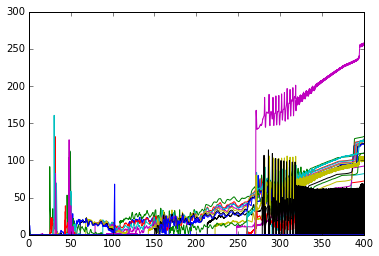

In [63]:
m2psi = 1.42
t = linspace(0,Ttot,shape(Hs)[1])
for k in range(0,Np):
    plot(t,m2psi*Hs[k,:])

0.000834028356964
100
91.0
71.0
101.0
[ 116.  214.   57.   62.   70.   37.   73.   77.   75.  101.   77.   82.
   41.   39.   75.  108.  104.   58.   91.   71.  101.   74.  123.   40.
   58.   19.   20.  256.  130.]


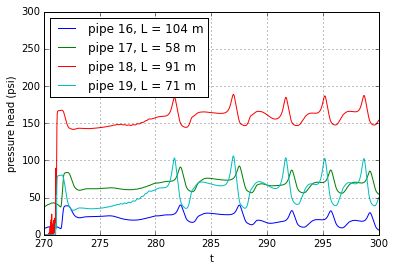

In [68]:

interesting = [16,17,18,19]
for i in interesting:
    plot(t,m2psi*Hs[i,:],label= 'pipe %d, L = %.f m'%(i,n1.Ls[i]))
print dt
print a
xlim(270,300)
#xticks(linspace(280,290,11))
grid(True)
xlabel('t')
ylabel('pressure head (psi)')
print n1.Ls[18]
print n1.Ls[19]
print n1.Ls[20]
legend(loc = 'upper left')
print n1.Ls

In [15]:
n1.solve_time*Nt

3416.69124

182
400


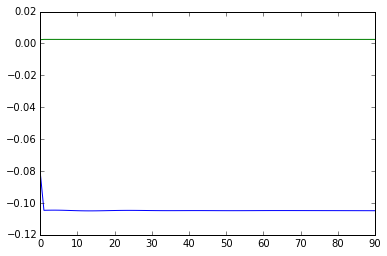

In [16]:
L = len(n1.q(18))
plot(n1.q(18)[L/2:])
print L
plot(n1.q(18)[0:L/2])
print Ttot

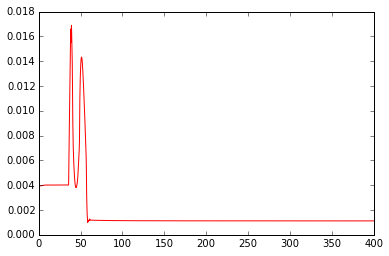

In [17]:
#plot(t,Hs[8,:],'g')
plot(t,Hs[22,:],'r')

In [18]:
import pickle
import time
Note = "initial condition is 0.05*Af everywhere except pipe 1, where it's (A0,Q00) with A0 =0.00793. \
    boundary condition is Q00 at node 0. \
    all other junctions have r = -1 \
    base inp file is alamaded52.0.0.inp"

In [19]:
solve_t = (n1.solve_time)*Nt
t = time.localtime()
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
f1=  open('results_saved_at%s.pkl'%s,'wb')
data = {'Hs':Hs, 'elevs':elevs_m,'T':T,'Tot':Ttot,
        'conns': n1.conn, 'Ds': n1.Ds, 'Ls':n1.Ls,'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':'bv',
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note}
pickle.dump(data,f1)
f1.close()

In [51]:
print f1

<closed file 'results_saved_at2015_10_18_22_27_19.pkl', mode 'wb' at 0x178047810>


In [26]:
import time

In [53]:
print Vs[-1]
Vsys = 0
for i in range(Np):
    D = n1.Ds[i]
    L = n1.Ls[i]
    Vsys+=(pi*(D**2)/4.*L)
print Vsys
print Q00*Ttot*2

9.71321597543
14.4100928029
1.74


In [54]:
t = time.localtime()
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
print s

2015_10_16_13_45_55


In [55]:
time.localtime()

time.struct_time(tm_year=2015, tm_mon=10, tm_mday=16, tm_hour=13, tm_min=45, tm_sec=55, tm_wday=4, tm_yday=289, tm_isdst=1)

In [56]:
ls

7deSeptiembre.ipynb                      filling_n_stuff.ipynb                    results_saved_at2015_10_13_16_3_30.pkl
Alameda_run_awhile.ipynb                 fillingdata_even_longer.pkl              results_saved_at2015_10_16_13_23_4.pkl
Alameda_test.ipynb                       fillingdata_slope0.pkl                   results_saved_at2015_10_16_13_23_55.pkl
Chlorine Modeling.ipynb                  fillingdata_slopenot0.pkl                results_saved_at2015_10_16_13_23_59.pkl
Convergence.ipynb                        fillingdata_slopenot0_longer.pkl         results_saved_at2015_10_16_13_24_22.pkl
Untitled.ipynb                           fillingdataslope_not0_run0.pkl           results_saved_at2015_10_16_13_24_6.pkl
Untitled1.ipynb                          fillingdataslope_not0_run1.pkl           results_saved_at2015_10_16_13_45_54.pkl
Untitled2.ipynb                          geomconfirm1.txt                         run_restart.py
Untitled3.ipynb                          geomconfirm